Simulation of Curveball in Football
===================================

Let us approximate a football as a smooth sphere of mass $m$ flying through air (density $\rho$). I will consider three main forces acting on the ball:

1. Gravity ${\bf g} = -g \hat{\bf z}$ acting downwards.
2. Air resistance acting opposite to the motion.
3. Magnus effect due to the spin of the ball.

I will consider these forces one by one to understand the differeces.

Basic Data Structures
----------------------

To store the data for the ball and the surrounding world, I will use two base classes: ``BallData`` to for the ball, storing information such as ball mass, radius etc and ``WorldData`` for the world settings such as gravity, air density, drag and spin coefficents (these two will be described later).

In [1]:
import numpy as np
from numpy import pi as PI 

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
class WorldData:
    """ Stores the world settings. """

    __slots__ = 'g', 'airDensity', 'dragConst', 'spinConst', 

    def __init__(self, g: float, airDensity: float, dragConst: float, spinConst: float):

        self.g = np.asfarray([0., 0., -g])
        self.airDensity = airDensity
        self.dragConst  = dragConst
        self.spinConst  = spinConst

world = WorldData(g = 9.8, airDensity = 1.2754, dragConst = 0.4, spinConst = 0.5) # default world

class BallData:
    """ Stores information about a ball. """

    __slots__ = (
                    'radius', 'mass', 'crossArea', 'volume', # ball specification
                    'pos', 'vel', 'acc', 'spin', 't',        # dynamical variables
                    'world', 'dragFactor', 'spinFactor'  
                )

    def __init__(self, mass: float, circ: float):

        self.mass   = mass
        self.radius = circ / (2*PI)

        self.crossArea = PI * self.radius**2
        self.volume    = 4./3 * PI * self.radius**3

    def setWorld(self, world: WorldData):
        """ Link this ball to the world. """
        
        self.world = world

    def setInitial(self, pos: list, vel: list, spin: list = None):
        """ Set up ball initial conditions. """

        self.pos  = np.asfarray(pos)
        self.vel  = np.asfarray(vel)
        self.acc  = np.asfarray([0., 0., 0.])

        self.t    = 0.0
        
        if spin is None:
            self.spin = np.asfarray([0., 0., 0.])
        else:
            self.spin = np.asfarray(spin)

Equation of Motion
-------------------

If the force on the ball is ${\bf F}$, then the equation of motion is given by Newton's second law, 

$$ m \ddot{\bf x} = {\bf F} $$

Solving the Equation of Motion
------------------------------

I will use the Euler method to numerically integrate the equations of motion.

$$
    {\bf x}_{i+1} = {\bf x}_i + {\bf v}_i {\rm d}t ~~\text{and}~~
    {\bf v}_{i+1} = {\bf v}_i + {\bf a}_i {\rm d}t
$$

This is first order method and a less accurate solver, especially for large time steps. For accurate results, other methods such as RK4 may be used.

In [3]:
def updateBall(ball: BallData, dt: float):

    ball.pos = ball.pos + ball.vel * dt
    ball.vel = ball.vel + ball.acc * dt

    # reset acceleration
    ball.acc = np.asfarray([0., 0., 0.])

    ball.t = ball.t + dt
    return

Forces on the Ball
-------------------

Let us consider the ball moving only under gravity ${\bf g} = -g \hat{\bf z}$. Then, 

$$ {\bf F} = m \ddot{\bf x} = m{\bf g} $$

In [4]:
def applyGravity(ball: BallData):

    ball.acc = ball.acc + ball.world.g
    return


This second order ODE can be solved, given the initial position ${\bf x}_0$ and velocity ${\bf v}_0$, 

$$ 
    {\bf x} = {\bf x}_0 + {\bf v}_0 t + \frac{1}{2} {\bf g}t^2 ~\text{and}~ 
    {\bf v} = {\bf v}_0 + {\bf g}t 
$$

**Special Case**: If we take ${\bf x}_0 = (0, 0, 0)$ and ${\bf v}_0 = (v_{0x}, 0, v_{0z})$, this becomes the equation for a parabola in the x-z plane. 
$$
    z = v_{0z} t - \frac{1}{2} gt^2 ~~\text{and}~~ x = v_{0x}t
$$

The maximum height $H$ reached by the ball is given by setting the z component of velocity to zero, which gives $v_{0z} - gt = 0$ or the time $t = v_{0z} / g$. This gives $ H = {v_{0z}^2}/(2g) $. If the ball is kicked at $t = 0$, the time taken for the ball to fall to ground ($z = 0$) will be $ T = {2v_{0z}}/{g} $,  and the maximum range the ball can go is the x value at time $T$, $ R = {2 v_{0x} v_{0z} }/{g} $.


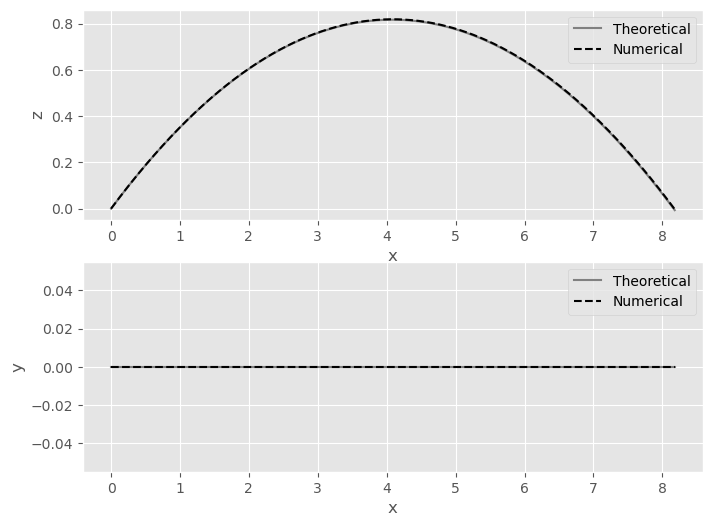

In [38]:
def _gravityOnlyTest():

    x0, v0 = np.asfarray([0.,0.,0.]), np.asfarray([10.,0.,4.])

    ball = BallData(mass=0.45, circ=0.7)
    ball.setInitial(pos=x0, vel=v0)
    ball.setWorld(world)

    t, pos, speed = [0.0], [ball.pos], [ np.sqrt( np.sum(v0**2) ) ]
    while True:

        applyGravity(ball)
        updateBall(ball, 0.001)

        t.append(ball.t)
        pos.append(ball.pos)
        speed.append( np.sqrt( np.sum(ball.vel**2) ) )

        if ball.pos[2] <= 0.:
            break

    t, pos, speed = np.asfarray(t), np.asfarray(pos), np.asfarray(speed)

    posTh = x0 + v0 * t[:, None] + 0.5*ball.world.g * t[:, None]**2

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8, 6])
    
    ax1.plot(posTh[:,0], posTh[:,2], '-', color = 'gray', label='Theoretical')
    ax1.plot(pos[:,0], pos[:,2], '--', color = 'black', label='Numerical')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()

    # ax3 = ax1.twinx()
    # ax3.plot(pos[:,0], speed, '--', color="tab:blue", label='With Drag')
    # ax3.set_ylabel('Speed', color='tab:blue')
    # ax3.grid()

    ax2.plot(posTh[:,0], posTh[:,1], '-', color = 'gray', label='Theoretical')
    ax2.plot(pos[:,0], pos[:,1], '--', color = 'black', label='Numerical')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.show()
        
        

_gravityOnlyTest()




**Observations**: With gravity only, the ball follows a symmetric path, confined only to one plane (no sideways / lateral motion). But, in real life games, two things are noted:

1. The ball falls more steaper than it climbs, leading to a asymmetric path (e.g., see a goal kick or long ranger).
2. Balls with right spin moves in a curled path. e.g., curving freekicks and olympic goals.

So, we consider the drag force also.

Drag on the ball is the air resitance to the ball's motion, which acts opposite to the motion. This will make the ball to loss its energy and eventually fall before the expected point. The drag force is assumed to be of the form

$$ {\bf F}_d = -b{\bf v} ~~\text{where}~~ b = \frac{1}{2} \rho A v C_D $$

where $A = \pi a^2$ is the ball's cross section area and $a$ is the radius and $C_D$ is the drag coefficient. This number depends on the ball properties, but I will take it as a free parameter. Now, the total force will be

$$ {\bf F} = m \ddot{\bf x} = m{\bf g} - b{\bf v} $$

In [16]:
def computeDragFactor(ball: BallData):

    ball.dragFactor = 0.5 * ball.world.airDensity * ball.crossArea * ball.world.dragConst # b
    return

def applyDrag(ball: BallData):

    speed    = np.sqrt( np.sum( ball.vel**2 ) ) # v = vx^2 + vy^2 + vz^2
    ball.acc = ball.acc - ball.dragFactor * speed * ball.vel / ball.mass
    return

Now the path will be asymetrical, because work will be done against the air drag, causing the energy of the ball to drop!

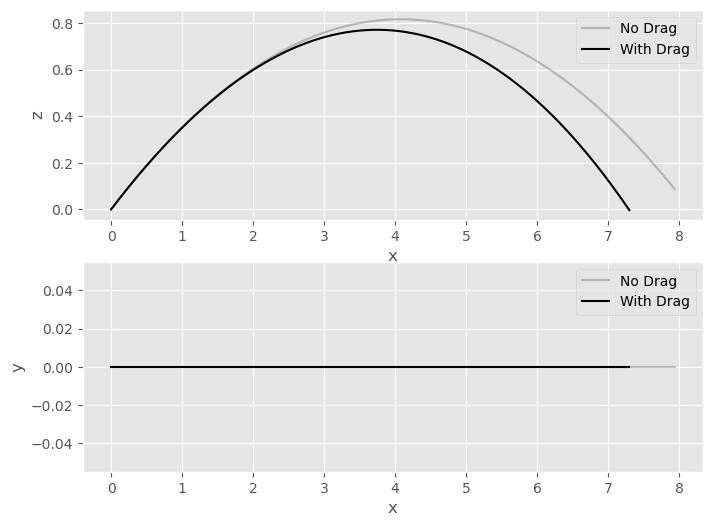

In [39]:
def _gravityDragTest():

    x0, v0 = np.asfarray([0.,0.,0.]), np.asfarray([10.,0.,4.])

    ball = BallData(mass=0.45, circ=0.7)
    ball.setInitial(pos=x0, vel=v0)
    ball.setWorld(world)

    computeDragFactor(ball)

    t, pos, speed = [0.0], [ball.pos], [ np.sqrt( np.sum(v0**2) ) ]
    while True:

        applyGravity(ball)
        applyDrag(ball)
        updateBall(ball, 0.001)

        t.append(ball.t)
        pos.append(ball.pos)
        speed.append( np.sqrt( np.sum(ball.vel**2) ) )

        if ball.pos[2] <= 0.:
            break

    t, pos, speed = np.asfarray(t), np.asfarray(pos), np.asfarray(speed)

    t1 = t[:, None]
    g  = ball.world.g

    posNoDrag = x0 + v0 * t1 + 0.5*g * t1**2

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8, 6])
    
    ax1.plot(posNoDrag[:,0], posNoDrag[:,2], '-', color="gray", alpha=0.5, label='No Drag')
    ax1.plot(pos[:,0], pos[:,2], '-', color="black", label='With Drag')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()

    # ax3 = ax1.twinx()
    # ax3.plot(pos[:,0], speed, '--', color="tab:blue", label='With Drag')
    # ax3.set_ylabel('Speed', color='tab:blue')
    # ax3.grid()

    ax2.plot(posNoDrag[:,0], posNoDrag[:,1], '-', color="gray", alpha=0.5, label='No Drag')
    ax2.plot(pos[:,0], pos[:,1], '-', color="black", label='With Drag')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.show()
        
        

_gravityDragTest()

Magnus effect is the tendency of a spinning, translating ball to be deflected laterally, that is, in a direction perpendicular to both its spin and motion. If the ball’s spin is $s$ then Magnus force is 

$$
    {\bf F}_m = c {\bf s} \times {\bf v} ~~\text{where}~~ c = V\rho C_M
$$

where $V = 4\pi a^3 / 3$ is the volume of the ball and $C_M$ is the coefficient of magnus force (takes as a free parameter). This force will make the ball deflect from the plane, in a direction perpendicular to both its spin and velocity. Now, the total force is 

$$ {\bf F} = m \ddot{\bf x} = m{\bf g} - b{\bf v} + c {\bf s} \times {\bf v} $$

In [8]:
def computeSpinFactor(ball: BallData):

    ball.spinFactor = ball.volume * ball.world.airDensity * ball.world.spinConst # c
    return 

def applySpin(ball: BallData):

    ball.acc = ball.acc + ball.spinFactor * np.cross( ball.spin, ball.vel ) / ball.mass
    return

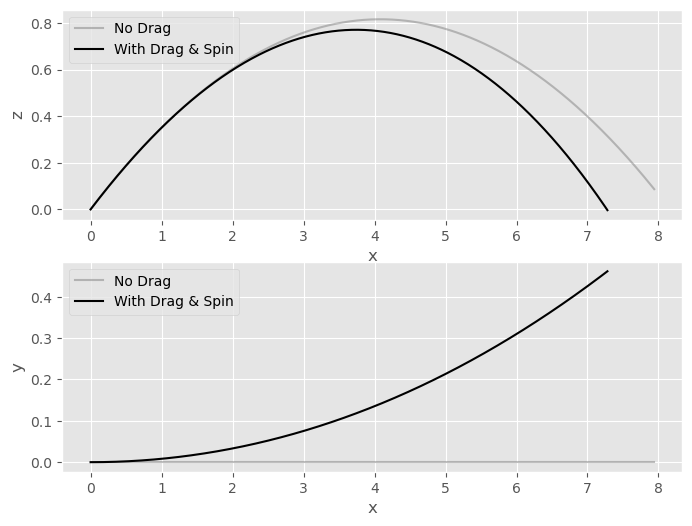

In [40]:
def _gravityDragSpinTest():

    x0, v0 = np.asfarray([0.,0.,0.]), np.asfarray([10.,0.,4.])
    spin   = np.asfarray([0., 0., 20.])

    ball = BallData(mass=0.45, circ=0.7)
    ball.setInitial(pos=x0, vel=v0, spin=spin)
    ball.setWorld(world)

    computeDragFactor(ball)
    computeSpinFactor(ball)

    t, pos, speed = [0.0], [ball.pos], [ np.sqrt( np.sum(v0**2) ) ]
    while True:

        applyGravity(ball)
        applyDrag(ball)
        applySpin(ball)
        updateBall(ball, 0.001)

        t.append(ball.t)
        pos.append(ball.pos)
        speed.append( np.sqrt( np.sum(ball.vel**2) ) )

        if ball.pos[2] <= 0.:
            break

    t, pos, speed = np.asfarray(t), np.asfarray(pos), np.asfarray(speed)

    t1 = t[:, None]
    g  = ball.world.g

    posNoDrag = x0 + v0 * t1 + 0.5*g * t1**2

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8, 6])
    
    ax1.plot(posNoDrag[:,0], posNoDrag[:,2], '-', color="gray", alpha=0.5, label='No Drag')
    ax1.plot(pos[:,0], pos[:,2], '-', color="black", label='With Drag & Spin')
    ax1.set_xlabel('x')
    ax1.set_ylabel('z')
    ax1.legend()

    # ax3 = ax1.twinx()
    # ax3.plot(pos[:,0], speed, '--', color="tab:blue", label='With Drag')
    # ax3.set_ylabel('Speed', color='tab:blue')
    # ax3.grid()

    ax2.plot(posNoDrag[:,0], posNoDrag[:,1], '-', color="gray", alpha=0.5, label='No Drag')
    ax2.plot(pos[:,0], pos[:,1], '-', color="black", label='With Drag & Spin')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.show()
        
        

_gravityDragSpinTest()

The `Ball` Class
----------------

Now, combine all of them together to make a working `Ball` class.

In [35]:
class Ball(BallData):

    __slots__ = 'path', 

    def __init__(self, mass: float, circ: float):
        super().__init__(mass, circ)

        self.path = []

    def setInitial(self, pos: list, vel: list, spin: list = None):
        return super().setInitial(pos, vel, spin)

    def setWorld(self, world: WorldData):
        
        self.dragFactor = 0.5 * world.airDensity * self.crossArea * world.dragConst # b
        self.spinFactor = self.volume * world.airDensity * world.spinConst          # c
        return super().setWorld(world)

    def applyForces(self, drag: bool = False, spin: bool = False):
        """ Apply forces on the ball. """

        self.acc = self.acc + self.world.g # apply gravity

        # apply drag
        if drag:
            speed    = np.sqrt( np.sum( self.vel**2 ) ) # v = vx^2 + vy^2 + vz^2
            self.acc = self.acc - self.dragFactor * speed * self.vel / self.mass

        # apply spin
        if spin:
            self.acc = self.acc + self.spinFactor * np.cross( self.spin, self.vel ) / self.mass

        return

    def update(self, dt: float = 0.01):
        """ Update ball position and speed """
        
        self.pos = self.pos + self.vel * dt
        self.vel = self.vel + self.acc * dt

        # reset acceleration
        self.acc = np.asfarray([0., 0., 0.])

        self.t = self.t + dt
        return

    def pushPosition(self):
        """ Save current position of the ball """
        
        return self.path.append( self.pos )

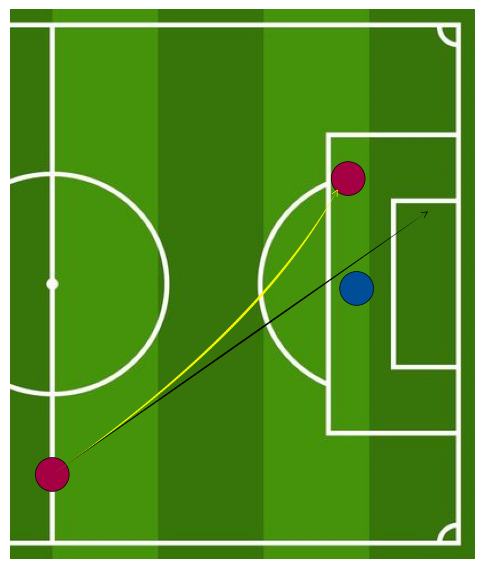

In [84]:

from matplotlib.collections import LineCollection

def toSpherical(mag: float, phi: float, theta: float):

    phi, theta = phi * PI / 180, theta * PI / 180
    return mag * np.asfarray([ np.cos(theta) * np.cos(phi), np.cos(theta) * np.sin(phi), np.sin(theta) ])


posInit = np.asfarray([50., 10., 0.])
velInit = toSpherical( mag=55., phi=35., theta=5. )
spin    = toSpherical( mag=40., phi=0.0, theta=45. )


ball = Ball( mass=0.4, circ=0.7 )
ball.setWorld( world )
ball.setInitial( pos=posInit, vel=velInit, spin=spin )
ball.pushPosition()

while True:

    ball.applyForces( drag=True, spin=True )
    ball.update()
    ball.pushPosition()

    if ball.pos[2] <= 0.:
        break
    
ballGOnly = Ball( mass=0.4, circ=0.7 )
ballGOnly.setWorld( world )
ballGOnly.setInitial( pos=posInit, vel=velInit, spin=spin )
ballGOnly.pushPosition()

while True:

    ballGOnly.applyForces( drag=False, spin=False )
    ballGOnly.update()
    ballGOnly.pushPosition()

    if ballGOnly.pos[2] <= 0.:
        break

fig, ax = plt.subplots(1, 1, figsize = [6,8])

ax.imshow( plt.imread('ground.png'), origin='lower', extent = [0, 100, 0, 65] )

ax.add_patch( plt.Circle( [50.0, 10.0], 2.0, facecolor = '#a50044', edgecolor = 'black' ) ) # player 1 team 1
ax.add_patch( plt.Circle( [85.0, 45.0], 2.0, facecolor = '#a50044', edgecolor = 'black' ) ) # player 2 team 1
ax.add_patch( plt.Circle( [86.0, 32.0], 2.0, facecolor = '#004d98', edgecolor = 'black' ) ) # player 1 team 2

path = np.asfarray(ball.path)
segments, widths = list(zip(path[:-1,:2], path[1:,:2])), 0.5*(path[:-1,2] + path[1:,2])
lc1   = LineCollection( segments=segments, linewidths=widths, color='yellow' )
ax.add_collection(lc1)
ax.annotate("", xy=segments[-1][1], xytext=segments[-1][0], arrowprops=dict(arrowstyle="->", color="yellow"))

path = np.asfarray(ballGOnly.path)
segments, widths = list(zip(path[:-1,:2], path[1:,:2])), 0.5*(path[:-1,2] + path[1:,2])
lc2   = LineCollection( segments=segments, linewidths=widths, color='black' )
ax.add_collection(lc2)
ax.annotate("", xy=segments[-1][1], xytext=segments[-1][0], arrowprops=dict(arrowstyle="->", color="black"))

ax.axis('off')
ax.set( xlim=[45, 100] )

plt.show()